# INFO4304 - VISION PAR ORDINATEUR (H2022)
## Résoudre un sudoku par capture d'image
Ce projet a comme but de prendre une image d'une sudoku incomplet, et de retourner cette même image avec la solution en placant des chiffres dans les cases vides. Pour accomplir cela, plusieurs étapes sont nécessaire et celles-ci sont décrites ci-dessous.

### Alex Savoie (A00188646)

### Importer les librairies

In [1]:
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import time as t

In [3]:
print("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 4.5.5 


### Fonction pour traitement d'image
La première étape est de traiter l'image. L'image est, en premier lieu, fixer à une résolution de 960x540. On évite de travailler avec des images ayant trop de pixels car cela ralentit légèrement certains algorithmes. Par la suite, un filtre Gaussien est appliqué pour réduire le bruit, en cas si du bruit est présent dans l'image. L'image est ensuite transformée en noir et blanc pour que celle-ci soit mieux reconnu par notre réseau neurone convolutif (cela viendra plus tard)

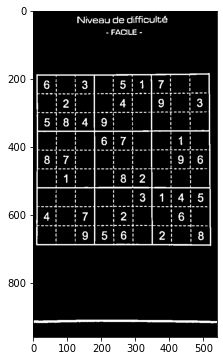

In [2]:
#Changer image sudoku ici
image = cv2.imread('./image/sudoku4.jpg')
height = 960
width = 540
imgBlank = np.zeros((height, width, 3), np.uint8)

def preProcess(img):
    img = cv2.resize(img, (width, height))
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    blur_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
    imgThreshold = cv2.adaptiveThreshold(blur_image, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV ,39 ,13)
    #img_erosion = cv2.erode(imgThreshold, kernel, iterations=1)  #Peut etre utile si les chiffres sont trop gras
    return gray_image, imgThreshold



gray_image, blackwhiteimg = preProcess(image)


plt.figure(figsize = (10,6))
plt.imshow(blackwhiteimg,cmap='gray')
plt.show() 

### Trouver les bordures du Sudoku
Utiliser la méthode findContours de OpenCV pour trouver TOUTES les bordures de l'image

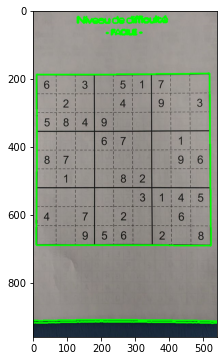

In [3]:
imgContours = image.copy()
imgBigCountours = image.copy()

contours, hierarchy = cv2.findContours(blackwhiteimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 3)

plt.figure(figsize = (10,6))
plt.imshow(imgContours,cmap='gray')
plt.show() 

### Fonction pour trouver la plus grande bordure
Fonction qui sert à trouver la bordure principale sur l'image. Cette bordure devrait, en théorie, être la bordure extérieur de notre sudoku. La fonction retourne les coordonées des 4 coins des la grille sudoku.

In [8]:
#Prend en parametres tout les bordures trouver sur l'image
def bigContour(contours):
    biggest = np.array([])
    max_area = 0
    #Regarde toutes les bordures un-par-un
    for i in contours: 
        area = cv2.contourArea(i)
        #Si l'aire de la bordure est trop petit -> bruit
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)  #Fonction qui permet d'approximer le nombre de coins
            #Si la nouvelle aire est maximal et que le nombre de coins == 4
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area  #biggest contient les coordonnees des coins et max_area est l'aire de la bordure

### Fonction pour re-arrangement des coins en ordres

Nos coins doivent être placés en ordre. Cela est utile lorsqu'on fera le warp perspectives lors de la prochaine étape.

In [9]:
def reOrder(corners):
    corners = corners.reshape((4,2))
    new_corners =  np.zeros((4, 1, 2), dtype=np.int32)
    add = corners.sum(1)
    new_corners[0] = corners[np.argmin(add)]  #Le coin en haut a gauche
    new_corners[3] = corners[np.argmax(add)]  #Le coin en bas a droite
    diff = np.diff(corners, axis=1)
    new_corners[1] = corners[np.argmin(diff)] #Le coin en haut a droite
    new_corners[2] = corners[np.argmax(diff)] #Le coin en bas a gauche
    return new_corners
    

### Transformation d'image
On fait un 'zoom' sur la grille sudoku en utilisant les 4 coins trouvés précédemment dans le but d'éliminer tout ce qui se retrouve autour et seulement garder la grille comme tel. Ensuite, cette nouvelle image aura un résolution de 450x450. Il est important que la hauteur et la largeur de l'image soit divisible par 9.

In [10]:
#Taille de notre grille sudoku (le nombre doit etre divisible par 9 pour pouvoir completer la subdivision (plus tard))
sud_height = sud_width = 450

biggest, maxArea = bigContour(contours)
if biggest.size != 0:
    biggest = reOrder(biggest)
    cv2.drawContours(imgBigCountours, biggest, -1, (0, 255, 0), 10)
    coins_sud = np.float32(biggest)  #Les coins des notre sudoku
    coins_img = np.float32([[0, 0], [sud_width, 0], [0, sud_height], [sud_width, sud_height]]) #Les coins de l'image
    mat = cv2.getPerspectiveTransform(coins_sud, coins_img)
    imgWarpColored = cv2.warpPerspective(image, mat, (sud_width, sud_height))
    imgDetectedDigits = imgBlank.copy()                         
    imgWarpColored = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY )

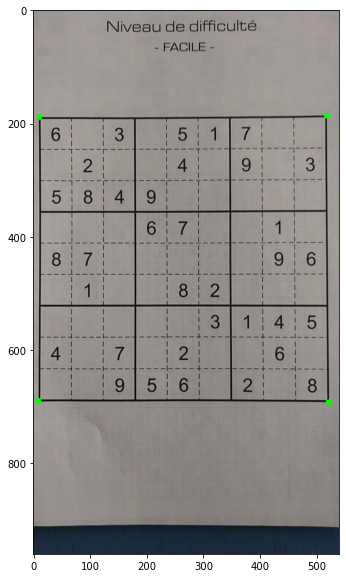

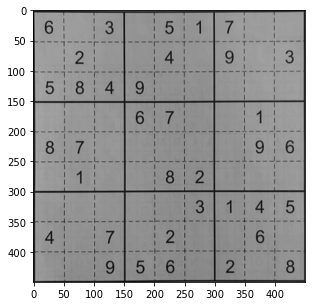

In [11]:
plt.figure(figsize = (15,10))
plt.imshow(imgBigCountours,cmap='gray', vmin = 0, vmax = 255)  #display image with gray scale color map
plt.show()  

plt.figure(figsize = (5,5))
plt.imshow(imgWarpColored,cmap='gray', vmin = 0, vmax = 255)  #display image with gray scale color map
plt.show()  

### Identification des grilles

Fonction qui permet de définir la subdivision de notre sudoku. Notre image sera subdiviser en 81 nouvelles images (9 fois à la verticale et 9 fois à l'horizontale). Ces 81 nouvelles images correspondent aux 81 différentes cases de notres grilles. Ces images sont placées dans un tableau qui passera par la suite dans le CNN.

In [12]:
def divGrilles(img):
    rangee = np.vsplit(img, 9)  #Vertical split
    grilles=[]
    for i in rangee:
        cols= np.hsplit(i,9)  #Horizontal split
        for j in cols:
            grilles.append(j)
    return grilles

Initialement, notre modèle CNN ne fonctionnaient pas à la perfection. Cela semble est grandement dû au fait que les chiffres dans nos images sont trop 'gras'. Plutôt que de changer mon dataset pour l'entrainement de mon CNN, j'ai ajouter de l'érosion à mes images pour amincir les chiffres. Aussi, certaines images contiennent des bordures noires vers les extrémité de l'image. J'ai donc éliminé quelques pixels situé vers l'extérieur de l'image. Maintenant notre CNN semble être en mesure de bien détecter tous les chiffres.

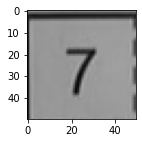

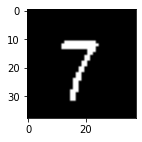

In [13]:
imgSolved = imgBlank.copy()
grilles = divGrilles(imgWarpColored)
grillesV2 = []

for i in grilles:
    face = i[7:45, 7:45]
    (thresh, gray) = cv2.threshold(face, 128, 255, cv2.THRESH_BINARY)
    gray = cv2.bitwise_not(gray)
    kernel = np.ones((2,2), np.uint8)
    gray = cv2.erode(gray, kernel, iterations=1)
    grillesV2.append(gray)  


plt.figure(figsize = (2,2))
plt.imshow(grilles[6],cmap='gray', vmin = 0, vmax = 255)
plt.show()  

plt.figure(figsize = (2,2))
plt.imshow(grillesV2[6],cmap='gray', vmin = 0, vmax = 255)
plt.show()  

### Model training
Modèle CNN utilisé pour détecter les chiffres dans chacune des cases de notre sudoku. Pour simplifier les choses, les cases vides seront considérées comme des 0. Notre modèle est assez simple et contient très peu de couche car notre base de données contient beaucoup de données et la compilation de notre modèle a pris plusieurs minutes à compléter. Le modèle choisi est inspiré par celui trouvé sur ce site :

Jason Brownlee. How to Develop a CNN for MNIST Handwritten Digit Classification. Deep Learning for Computer Vision (Machine Learning Mastery). May 2019. https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

In [109]:

from keras.datasets import mnist

(X_train,Y_train),(X_test,Y_test)=mnist.load_data()

In [110]:
print(X_train.shape,Y_train.shape)

X_train =X_train.reshape(X_train.shape[0],28,28,1)
X_test =X_test.reshape(X_test.shape[0],28,28,1)
input_shape=(28,28,1)

(60000, 28, 28) (60000,)


In [111]:
import tensorflow as tf
Y_train=tf.keras.utils.to_categorical(Y_train,10)
Y_test=tf.keras.utils.to_categorical(Y_test,10)

In [112]:
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train/=255
X_test/=255
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [120]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [121]:
model=define_model()
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test), verbose=1)
    

Epoch 1/10
938/938 [==============================] - 21s 22ms/step - loss: 0.2089 - accuracy: 0.9366 - val_loss: 0.0960 - val_accuracy: 0.9715
Epoch 2/10
938/938 [==============================] - 19s 20ms/step - loss: 0.0773 - accuracy: 0.9775 - val_loss: 0.0697 - val_accuracy: 0.9772
Epoch 3/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0514 - accuracy: 0.9847 - val_loss: 0.0590 - val_accuracy: 0.9800
Epoch 4/10
938/938 [==============================] - 19s 21ms/step - loss: 0.0384 - accuracy: 0.9883 - val_loss: 0.0425 - val_accuracy: 0.9858
Epoch 5/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0297 - accuracy: 0.9909 - val_loss: 0.0454 - val_accuracy: 0.985999
Epoch 6/10
938/938 [==============================] - 20s 22ms/step - loss: 0.0241 - accuracy: 0.9930 - val_loss: 0.0444 - val_accuracy: 0.9854
Epoch 7/10
938/938 [==============================] - 24s 25ms/step - loss: 0.0186 - accuracy: 0.9950 - val_loss: 0.0383 - val_accurac

Sauvegarde du modele. Le modèle a prit une vingtaine de minutes pour compiler, je ne veux pas avoir à re-compiler le modèle à chaque fois que je ferme et ouvre mon projet!

In [122]:
model.save('./model/model2.h5')

score = model.evaluate(X_test, Y_test, verbose=1)
print("Test Lost, Test Accuracy:", score)

313/313 [==============================] - 8s 26ms/step - loss: 0.0391 - accuracy: 0.9875
Test Lost, Test Accuracy: [0.03910984471440315, 0.987500011920929]


Notre modèle avec peu de couche a quand même réussi à obtenir une exactitude de 98,75%.

In [149]:
model = tf.keras.models.load_model('./model/model2.h5')

Maintenant que notre modèle a terminé sa compilation, on l'applique sur nos 81 images de chacune de nos cases.

In [150]:
def obtenirPred(grilles, model):
    resultats = []
    for i in grilles:
        img = np.asarray(i)
        img = img[4:img.shape[0] - 4, 4:image.shape[1] -4]
        img = cv2.resize(img, (28,28))
        img = img.reshape(1,28,28,1)
        
        
        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis=1)
        probabilityValue = np.amax(predictions)
        #print(classIndex,probabilityValue)
        
        if probabilityValue > 0.9:
            resultats.append(classIndex[0])
        else: 
            resultats.append(0)
    return resultats
        

#### Affichage du résultat trouvé par notre modèle CNN

In [11]:
numbers = obtenirPred(grillesV2, model)
print(numbers)


[6, 0, 3, 0, 5, 1, 7, 0, 0, 0, 2, 0, 0, 4, 0, 9, 0, 3, 5, 8, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 0, 0, 1, 0, 8, 7, 0, 0, 0, 0, 0, 9, 6, 0, 1, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 4, 5, 4, 0, 7, 0, 2, 0, 0, 6, 0, 0, 0, 9, 5, 6, 0, 2, 0, 8]


#### Fonction affichage des chiffres

Fonction qui sert à remplir les cases vides avec les réponses trouvé par le solutionnaire. Il place ces chiffres manquant dans une nouvelle images qui sera ajouté au-dessus de l'image originale plus tard.

In [15]:
def affichageChiffre(img,numbers,color = (0,255,0)):
    w = int(img.shape[1]/9)
    h = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                 cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*w+int(w/2)-10, int((y+0.8)*h)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img

Le but de cette fonction est d'énumerer les cases vides par de 1 et les cases ayant déjà des chiffres par des 0. On veut que les parties ou il y a déjà des chiffres dans notre sudoku reste intact lors de l'affichage du résultat final au-dessus de l'image originale. 

In [16]:
imgDetectedDigits = affichageChiffre(imgDetectedDigits, numbers, color=(255,0,255))
numbers = np.asarray(numbers)
position = np.where(numbers > 0,0,1)
print(position)
#Donne des 0 ou les cases ont deja des chiffre et 1 lorsque les cases sont vide

[0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0
 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1
 0 0 0 1 0 1 0]


#### Algorithme solutionnaire du sudoku

Pour ne pas perdre trop de temps lors de ce projet, j'ai importé un programme trouvé sur Internet qui permet de résoudre une grille sudoku par 'backtracking'. L'algorithmes fonctionne très bien et réussi à résoudre un sudoku en moins d'une seconde. Voici le lien pour ce programme : 

TechWithTim. Python Solver with Backtracking. June 2019. Python Sudoku Solver w/ Backtracking - https://www.techwithtim.net/tutorials/python-programming/sudoku-solver-backtracking/

Si notre grille sudoku est impossible à résoudre, nos programme s'arrête ici et retourne l'image originale comme résultat finale. Sinon, les chiffres manquant de la grilles sont ajouté dans une nouvelle image.

In [17]:
board = np.array_split(numbers, 9)
print(board)

import solver

#Si la solution n'est pas trouvé, rien ne sera affiché
try:
    solver.solve(board)
except:
    pass

print(board)

flatList =[]
for sublist in board:
    for item in sublist:
        flatList.append(item)
solvedNumbers =flatList*position
imgSolved= affichageChiffre(imgSolved,solvedNumbers)

[array([6, 0, 3, 0, 5, 1, 7, 0, 0]), array([0, 2, 0, 0, 4, 0, 9, 0, 3]), array([5, 8, 4, 9, 0, 0, 0, 0, 0]), array([0, 0, 0, 6, 7, 0, 0, 1, 0]), array([8, 7, 0, 0, 0, 0, 0, 9, 6]), array([0, 1, 0, 0, 8, 2, 0, 0, 0]), array([0, 0, 0, 0, 0, 3, 1, 4, 5]), array([4, 0, 7, 0, 2, 0, 0, 6, 0]), array([0, 0, 9, 5, 6, 0, 2, 0, 8])]
[array([6, 9, 3, 2, 5, 1, 7, 8, 4]), array([7, 2, 1, 8, 4, 6, 9, 5, 3]), array([5, 8, 4, 9, 3, 7, 6, 2, 1]), array([3, 4, 5, 6, 7, 9, 8, 1, 2]), array([8, 7, 2, 3, 1, 5, 4, 9, 6]), array([9, 1, 6, 4, 8, 2, 5, 3, 7]), array([2, 6, 8, 7, 9, 3, 1, 4, 5]), array([4, 5, 7, 1, 2, 8, 3, 6, 9]), array([1, 3, 9, 5, 6, 4, 2, 7, 8])]


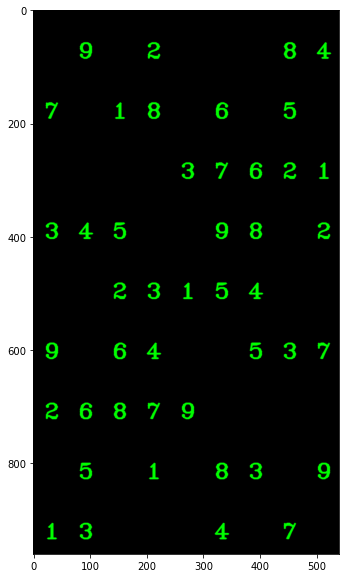

In [18]:
plt.figure(figsize = (10,10))
plt.imshow(imgSolved,cmap='gray', vmin = 0, vmax = 255)
plt.show()  

#### Affichage au-dessus the l'image initiale

L'image des chiffres pour les cases vides du sudoku est superposer à l'image originale pour obtenir une image avec le résultat final.

(-0.5, 539.5, 959.5, -0.5)

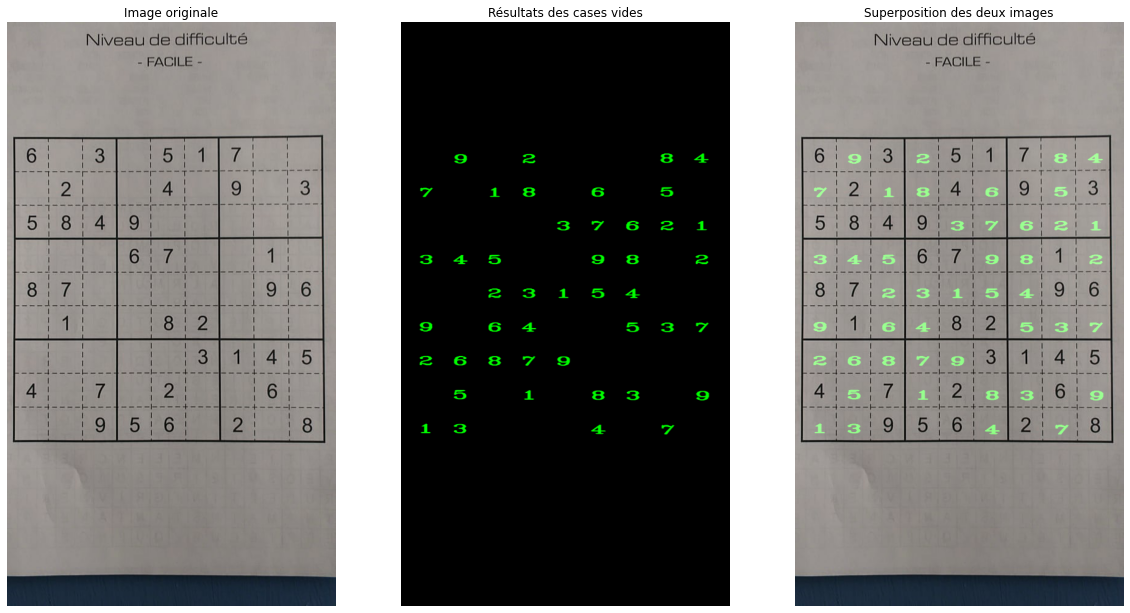

In [38]:
coins_img = np.float32(biggest)
coins_sud =  np.float32([[0, 0],[width, 0], [0, height],[width, height]])
matrix = cv2.getPerspectiveTransform(coins_sud, coins_img)
imgInvWarpColored = image.copy()
imgInvWarpColored = cv2.warpPerspective(imgSolved, matrix, (width, height))


inv_perspective = cv2.addWeighted(imgInvWarpColored, 1, image, 1, 1)


fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(image)
ax[0].set_title("Image originale")
ax[0].axis('off')
ax[1].imshow(imgInvWarpColored)
ax[1].set_title("Résultats des cases vides")
ax[1].axis('off')
ax[2].imshow(inv_perspective)
ax[2].set_title("Superposition des deux images")
ax[2].axis('off')

### Résultats et discussions

Malgré que notre programme semble très bien fonctionné, celui-ci contient certaines restrictions. Par exemple, l'image du sudoku doit initalement être dans la bonne orientation. Le programme est incapable de détecter et de corriger la rotation de l'image. Aussi, si une personne commence à écrire la solution avec une plume sur le sudoku, notre modèle CNN rencontre parfois des difficulté à comprendre l'écriture humaine. Il est grandement préférable d'utilisé l'image d'un sudoku incomplet qui n'a jamais été commencé. Une autre restriction est que, l'image du sudoku devrait être prise à l'aide du caméra qui prend des photo dans une résolution avec un ratio 16:9. Puisqu'on impose une résolution de 960x540 lors du prétraitement de l'image, si le ratio est différent, l'image sera 'stretch' et certains algorithmes du programme ne fonctionneront pas bien.

Autre que ces quelques restrictions, les résultats sont assez fiables et on peut conclure que les objectifs du projet ont été atteints.